## Лабораторная 3: метод ближайших соседей (kNN)

В рамках этого занятия мы будем создавать модель для предсказания выживших пассажиров на "Титанике" (классическое учебное Kaggle [соревнование](https://www.kaggle.com/c/titanic)).

![Титаник](http://staff.mmcs.sfedu.ru/~sguda/MachineLearning/titanic.png)

## 1

Загрузите данные о погибших в катастрофе с "Титаником". Целевым признаком здесь является факт спасения пассажира. Посмотрите на данные.

In [2]:
import pandas as pd

data = pd.read_csv('data.csv')




In [ ]:
# место для кода

In [ ]:
# место для кода

In [ ]:
# место для кода

Для простоты исключите пассажиров с неизвестным возрастом и заново перенумеруйте строки

*Функции, которые могут пригодиться при решении: `.dropna(subset=['Age']), .reset_index(drop=True)`*

In [4]:
data = data.dropna(subset=['Age'])
data = data.reset_index(drop=True)
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
709,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q
710,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
711,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
712,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


## 2

Постройте график рассеяния с возрастом в качестве оси абсцисс и ценой билета в качестве оси ординат. Отметьте красным — погибших, зеленым — спасшихся пассажиров. Постройте отдельно 2 графика: для женщин и для мужчин. 

Выполняется ли для данного множества гипотеза компактности?

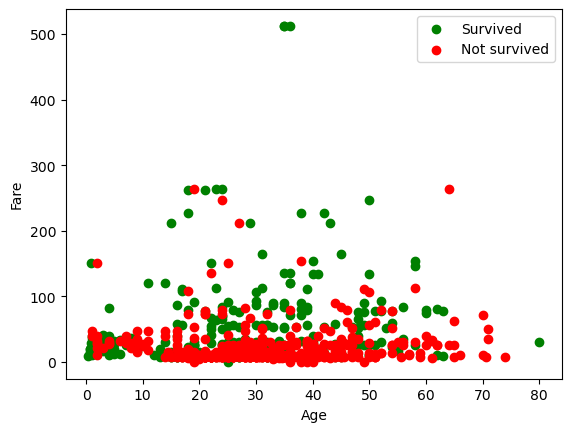

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
filtered_data = data[data['Age'].notnull()]

# Разобьем пассажиров на спасшихся и неспасшихся
survived_data = filtered_data[filtered_data['Survived'] == 1]
not_survived_data = filtered_data[filtered_data['Survived'] == 0]

# Построим график рассеяния
plt.scatter(survived_data['Age'], survived_data['Fare'], c='g', label='Survived')
plt.scatter(not_survived_data['Age'], not_survived_data['Fare'], c='r', label='Not survived')
plt.xlabel('Age')
plt.ylabel('Fare')
plt.legend()
plt.show()

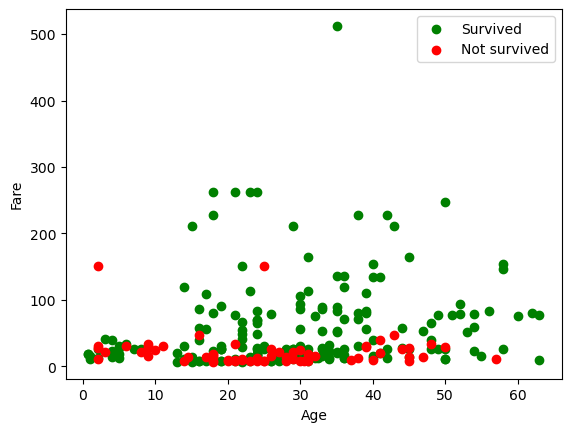

In [11]:
filtered_data = data[(data['Age'].notnull()) & (data['Sex'] == 'female')]
survived_data = filtered_data[filtered_data['Survived'] == 1]
not_survived_data = filtered_data[filtered_data['Survived'] == 0]
plt.scatter(survived_data['Age'], survived_data['Fare'], c='g', label='Survived')
plt.scatter(not_survived_data['Age'], not_survived_data['Fare'], c='r', label='Not survived')
plt.xlabel('Age')
plt.ylabel('Fare')
plt.legend()
plt.show()

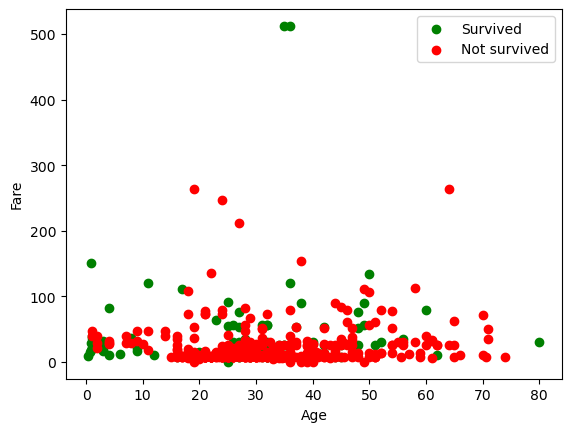

In [12]:
filtered_data = data[(data['Age'].notnull()) & (data['Sex'] == 'male')]
survived_data = filtered_data[filtered_data['Survived'] == 1]
not_survived_data = filtered_data[filtered_data['Survived'] == 0]
plt.scatter(survived_data['Age'], survived_data['Fare'], c='g', label='Survived')
plt.scatter(not_survived_data['Age'], not_survived_data['Fare'], c='r', label='Not survived')
plt.xlabel('Age')
plt.ylabel('Fare')
plt.legend()
plt.show()

## 3 

Для построения модели нам понадобится метрика близости пассажиров. Запрограммируем функцию вычисления расстояния между пассажирами:

In [13]:
def distance(a,b):
    d = 0
    d += abs(a['Pclass'] - b['Pclass'])
    d += a['Sex'] != b['Sex']
    d += abs(a['Age'] - b['Age'])
    d += abs(a['SibSp'] - b['SibSp'])
    d += abs(a['Parch'] - b['Parch'])
    d += abs(a['Fare'] - b['Fare'])
    d += a['Embarked'] != b['Embarked']
    return d

Метод `KNeighborsClassifier` из библиотеки `sklearn` излишне требователен к типам данных. Запрограммируем метод `k` ближайших соседей вручную:

In [14]:
import numpy as np
import tqdm

In [15]:
def myKNeighborsClassifier(learnData, K, passengerIndexForPrediction):
    dists = np.zeros((learnData.shape[0] - 1, 2))
    i = 0
    for idx, row in learnData.iterrows():
        if idx != passengerIndexForPrediction:  #LOO метод контроля ошибки
            dists[i][0] = distance(learnData.loc[passengerIndexForPrediction,], row)
            dists[i][1] = row['Survived']
            i += 1
    dists = sorted(dists, key = lambda pair: pair[0])
    prediction = 0
    for i in range(K): 
        prediction += dists[i][1]
    prediction /= K
    return round(prediction)

Запустите предсказание для всех пассажиров судна и, используя LOO-контроль ошибки оцените качество классификации:

In [16]:
accuracy = 0
for idx, row in tqdm.tqdm(data.iterrows(), total=len(data)):
    accuracy += row['Survived'] == myKNeighborsClassifier(data, 5, idx)
print(accuracy/data.shape[0])

100%|████████████████████████████████████████████████████████████████████████████████| 714/714 [02:23<00:00,  4.96it/s]

0.726890756302521


Подберите слагаемые в метрике, их веса и количество соседей так, чтобы качество классификации было максимальным. 

Если функция на `python` работает долго, воспользуйтесь ее аналогом на 
С++:  `KNeighborsClassifier.cpp.` 

Компиляция на Linux выполняется командой 

    g++ -O2 KNeighborsClassifier.cpp -o  KNeighborsClassifier


Запуск: 

    ./KNeighborsClassifier
    
Построившему метрику с наилучшим качеством: +5 бонусных баллов.

## 4

Создайте копию функции `myKNeighborsClassifier` и измените ее так, чтобы она считала выступ объекта. Назовите ее `calcMargin`. 

Вычислите выступы для всех объектов и выведите информацию о пяти объектах с минимальным выступом (шумовых выбросах) и пяти объектах с максимальным выступом (эталонах). Объясните в комментариях полученные данные.

In [17]:
def myKNeighborsClassifier(learnData, K, passengerIndexForPrediction):
    dists = np.zeros((learnData.shape[0] - 1, 2))
    i = 0
    for idx, row in learnData.iterrows():
        if idx != passengerIndexForPrediction:  #LOO метод контроля ошибки
            dists[i][0] = distance(learnData.loc[passengerIndexForPrediction,], row)
            dists[i][1] = row['Survived']
            i += 1
    dists = sorted(dists, key = lambda pair: pair[0])
    prediction = 0
    for i in range(K): 
        prediction += dists[i][1]
    prediction /= K
    margin = dists[K - 1][0] - dists[K][0] # выступ объекта
    return (round(prediction), margin)

In [19]:
margins = []
for idx, row in tqdm.tqdm(data.iterrows(), total=len(data)):
    pred, margin = myKNeighborsClassifier(data, 5, idx)
    margins.append(margin)
data['margin'] = margins

# выводим информацию о пяти объектах с минимальным и максимальным выступом
print("Шумовые выбросы (пять объектов с минимальным выступом):")
print(data.sort_values(by=['margin']).head())
print("\nЭталоны (пять объектов с максимальным выступом):")
print(data.sort_values(by=['margin'], ascending=False).head())

100%|████████████████████████████████████████████████████████████████████████████████| 714/714 [02:27<00:00,  4.83it/s]

Шумовые выбросы (пять объектов с минимальным выступом):
     PassengerId  Survived  Pclass  \
274          342         1       1   
67            89         1       1   
589          743         1       1   
23            28         0       1   
620          780         1       1   

                                                  Name     Sex   Age  SibSp  \
274                     Fortune, Miss. Alice Elizabeth  female  24.0      3   
67                          Fortune, Miss. Mabel Helen  female  23.0      3   
589              Ryerson, Miss. Susan Parker "Suzette"  female  21.0      2   
23                      Fortune, Mr. Charles Alexander    male  19.0      3   
620  Robert, Mrs. Edward Scott (Elisabeth Walton Mc...  female  43.0      0   

     Parch    Ticket      Fare            Cabin Embarked   margin  
274      2     19950  263.0000      C23 C25 C27        S -23.5208  
67       2     19950  263.0000      C23 C25 C27        S -22.9958  
589      2  PC 17608  262.3750  B57 

In [ ]:
# место для кода

Это легче всего сделать с помощью функции `np.argsort`, возвращающей индексы элементов в отсортированном ряду:

In [22]:
idxss = np.argsort(margins)
idxss

array([274,  67, 589,  23, 620, 248, 255, 216, 301, 546, 315, 304,  55,
       432,  54, 437, 414, 383, 208, 569, 262, 348, 122, 172, 351, 307,
       197,  95, 140, 587, 537, 241, 442, 592, 639, 401, 536, 156, 476,
       556, 395, 460, 662, 586, 669,  57,  33, 484, 521, 540, 298, 496,
       480,  93, 567, 120, 232, 551,  38, 664,  89,  10, 452,  71, 563,
       499,  66, 244, 421, 340, 681, 619, 175, 633, 272, 505, 146, 622,
       138,  36, 111, 481, 588, 405, 137, 331, 293, 108, 366, 433, 453,
       256, 342, 203, 407, 441, 174, 287, 107, 363,  27,  44, 581, 530,
       704, 451,  26, 345, 265, 711, 396, 507, 294, 412,  78, 149, 135,
       188, 223, 263, 310, 312, 609, 494, 541, 408, 253,  59, 482, 504,
       579, 493, 524, 282, 486, 322, 419, 251, 358,  94, 512,  79,  85,
       514,  25,  74,  15, 696, 429, 679, 222, 402, 680,  40, 271, 469,
         3, 422, 308,  91, 582, 548, 386, 538, 259,  60, 160, 686, 485,
       199, 243, 240, 370, 628, 349, 118, 119, 173, 267, 663, 38

In [23]:
print('Белые вороны (аномалии)')
data.loc[idxss[:5],]

Белые вороны (аномалии)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,margin
274,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.0000,C23 C25 C27,S,-23.5208
67,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.0000,C23 C25 C27,S,-22.9958
589,743,1,1,"Ryerson, Miss. Susan Parker ""Suzette""",female,21.0,2,2,PC 17608,262.3750,B57 B59 B63 B66,C,-18.9958
23,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.0000,C23 C25 C27,S,-16.9958
620,780,1,1,"Robert, Mrs. Edward Scott (Elisabeth Walton Mc...",female,43.0,0,1,24160,211.3375,B3,S,-16.1833


In [24]:
print('Эталоны (характерные объекты)')
data.loc[idxss[-5:],]

Эталоны (характерные объекты)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,margin
431,544,1,2,"Beane, Mr. Edward",male,32.0,1,0,2908,26.000,NaN,S,0.0
434,547,1,2,"Beane, Mrs. Edward (Ethel Clarke)",female,19.0,1,0,2908,26.000,NaN,S,0.0
435,549,0,3,"Goldsmith, Mr. Frank John",male,33.0,1,1,363291,20.525,NaN,S,0.0
376,473,1,2,"West, Mrs. Edwy Arthur (Ada Mary Worth)",female,33.0,1,2,C.A. 34651,27.750,NaN,S,0.0
713,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.750,NaN,Q,0.0
